In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob

import h5py
import flammkuchen as fl
import seaborn as sns
from matplotlib.cm import ScalarMappable
import scipy
from scipy import stats

In [3]:
def reshape_feature_array(feature_vector_array):
    """
    Reshape the feature vector array into a specified shape and extract sub-arrays.

    Parameters:
    - feature_vector_array: numpy.ndarray, the array to be reshaped.

    Returns:
    - reshaped_array: numpy.ndarray, the reshaped array.
    - peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array: separate sub-arrays.
    """
    max_n = int(feature_vector_array.shape[1] / 4)

    # Reshape the array
    reshaped_array = feature_vector_array.reshape(feature_vector_array.shape[0], 4, max_n)

    # Extract sub-arrays
    peaks_a_array = reshaped_array[:, 0, :]
    peaks_i_array = reshaped_array[:, 1, :]
    valleys_a_array = reshaped_array[:, 2, :]
    valleys_i_array = reshaped_array[:, 3, :]

    print(f"Reshaped array shape: {reshaped_array.shape}")

    return reshaped_array, peaks_a_array, peaks_i_array, valleys_a_array, valleys_i_array

In [4]:
def resort_ipsi_contra(tail, left_fin, right_fin, directionality):
    """
    Resorts left_fin, right_fin, left_eye, and right_eye based on directionality
    into ipsilateral and contralateral components.
    """
    tail_new = np.zeros_like(tail)
    ipsi_fin = np.zeros_like(left_fin)
    contra_fin = np.zeros_like(left_fin)
    ipsi_fin_id = np.zeros(len(left_fin))  # Initialize with 0 (for 'left')

    for i, dir_value in enumerate(directionality):
        if dir_value == 1:  # Left direction
            tail_new[i] = tail[i]
            ipsi_fin[i] = left_fin[i]
            contra_fin[i] = right_fin[i]
            ipsi_fin_id[i] = 0  # Set as 0 (for 'left')
        elif dir_value == 0:  # Right direction
            tail_new[i] = tail[i]
            ipsi_fin[i] = right_fin[i]
            contra_fin[i] = left_fin[i]
            ipsi_fin_id[i] = 1  # Set as 1 (for 'right')
    return tail_new, ipsi_fin, contra_fin,  ipsi_fin_id



def sort_tensor_ipsi_contra(tensor, directionality):
    """
    Sort the tensor signals into ipsilateral and contralateral components
    based on the detected directionality.

    Args:
    tensor (np.ndarray): The baseline-corrected tensor of shape (trials, signals, time points).

    Returns:
    tuple: The sorted and adjusted tensor, ipsilateral fin identities, 
           and indices of trials where fins were switched.
    """
    # Extract each signal
    tail = tensor[:, 0, :]
    left_fin = tensor[:, 1, :]
    right_fin = tensor[:, 2, :]

    # Resort fins and eyes into ipsilateral and contralateral components
    tail_new, ipsi_fin, contra_fin, ipsi_fin_id = resort_ipsi_contra(
       tail, left_fin, right_fin, directionality
    )
    
    # Create a new tensor with sorted and adjusted components
    new_tensor = np.stack([tail_new, ipsi_fin, contra_fin], axis=1)
    
    return new_tensor, ipsi_fin_id

In [5]:
sns.set_theme(style="white", palette="pastel")

In [6]:
master_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Raw_Data')

fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths

[WindowsPath('//portulab.synology.me/data/Kata/testdata/Raw_Data/240423_f0')]

In [7]:
fish= 0
fish_id =  fish_paths[fish].name
exp_name = Path(fish_paths[fish]).parts[-2]
exp_name = 'testfish'
fish_id, exp_name


('240423_f0', 'testfish')

In [8]:
out_path = Path(r'\\portulab.synology.me\data\Kata\testdata\Processed_Data')
save_data_path = out_path

In [9]:
t_feature_vector_array = fl.load(save_data_path/ '{}_t_feature_vector_array.h5'.format(fish_id))
l_feature_vector_array = fl.load(save_data_path/ '{}_l_feature_vector_array.h5'.format(fish_id))
r_feature_vector_array = fl.load(save_data_path/ '{}_r_feature_vector_array.h5'.format(fish_id))

In [10]:
## tail, left fin, right fin

tensor =  fl.load(out_path / '{}_tensor.h5'.format(fish_id))
tensor.shape

(500, 3, 50)

In [11]:
max_n = int(l_feature_vector_array.shape[1]/4)
max_n

9

In [12]:
t_reshaped_array, t_peaks_a_array, t_peaks_i_array, t_valleys_a_array, t_valleys_i_array = reshape_feature_array(t_feature_vector_array)
l_reshaped_array, l_peaks_a_array, l_peaks_i_array, l_valleys_a_array, l_valleys_i_array = reshape_feature_array(l_feature_vector_array)
r_reshaped_array, r_peaks_a_array, r_peaks_i_array, r_valleys_a_array, r_valleys_i_array = reshape_feature_array(r_feature_vector_array)


Reshaped array shape: (500, 4, 9)
Reshaped array shape: (500, 4, 9)
Reshaped array shape: (500, 4, 9)


In [13]:
laterality = fl.load(save_data_path/'{}_bout_laterality.h5'.format(fish_id))

## load data

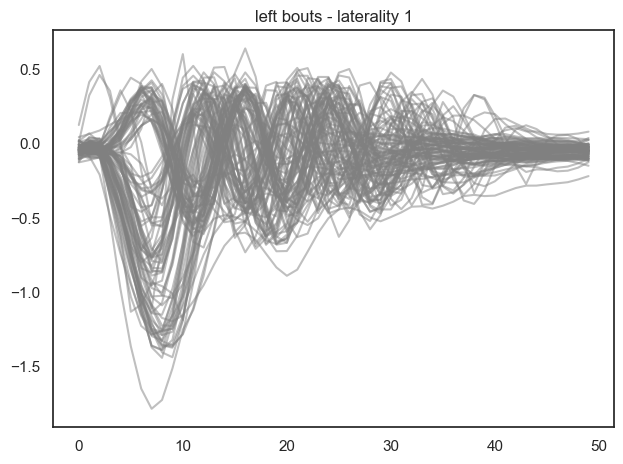

In [14]:
plt.figure()
plt.title('left bouts - laterality 1')
plt.plot(tensor[:, 0,:][laterality==1][:100].T, c='gray', alpha=0.5)

plt.tight_layout()

# Sort ipsi contra

In [15]:
sorted_tensor, ipsi_fin_ids = sort_tensor_ipsi_contra(tensor, laterality)
print (sorted_tensor.shape)
print("Ipsilateral fin identities:", ipsi_fin_ids)


(500, 3, 50)
Ipsilateral fin identities: [0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0.
 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 

### Plot example bout

395 0.0 1.0


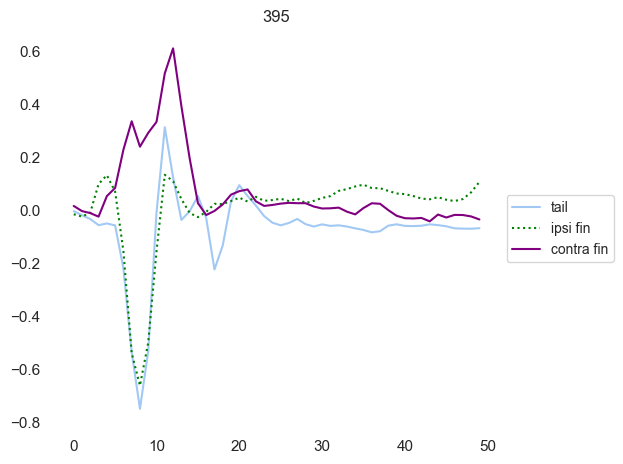

In [18]:
import random
f_size=10
bout = random.randrange(0, tensor.shape[0])

print (bout, ipsi_fin_ids[bout], laterality[bout]) # features.bout_angle.iloc[bout])

plt.figure()
plt.plot(sorted_tensor[bout, 0, :].T, label='tail')
plt.plot(sorted_tensor[bout, 1, :].T, c='green', ls=':', label='ipsi fin')
plt.plot(sorted_tensor[bout, 2, :].T, c='purple',  label='contra fin')
plt.title(bout)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=f_size)
sns.despine(top=True, right=True, left=True, bottom=True, offset=None, trim=False)
plt.tight_layout()

## save new tensor

In [40]:
fl.save(save_data_path/ '{}_tensor_ipsi_contra.h5'.format(fish_id), sorted_tensor)
fl.save(save_data_path/ '{}_ipsi_fin_ids.h5'.format(fish_id), ipsi_fin_ids)

In [41]:
save_data_path

WindowsPath('//portulab.synology.me/data/Kata/testdata/Processed_Data')